In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from bpitnorm.modules.BatchPitNormalization import BatchPitNorm1d

device = "cuda" if torch.cuda.is_available() else "cpu"

data = np.genfromtxt("Data/housing.csv", delimiter=",", skip_header=1)[:, :-1]
data = data[~(np.isnan(data)).any(axis=1)]
def data_split(data):
  X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data[:, :-1], data[:, -1], test_size=0.2, random_state=True)
  y_train_raw = y_train_raw.reshape(-1, 1)
  y_test_raw = y_test_raw.reshape(-1, 1)

  scaler1 = StandardScaler()
  scaler_x = scaler1.fit(X_train_raw)
  X_train = scaler_x.transform(X_train_raw)
  X_test = scaler_x.transform(X_test_raw)

  scaler2 = StandardScaler()
  scaler_y = scaler2.fit(y_train_raw)
  y_train = scaler_y.transform(y_train_raw)
  y_test = scaler_y.transform(y_test_raw)

  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train, dtype=torch.float32, device=device).reshape(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
  y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device=device)
  return X_train, y_train, X_test, y_test, scaler_y

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

def train_model(model, loops):
    model.to(device=device)
    r2score_lst = np.zeros(loops)
    meanAbsoluteError_lst = np.zeros(loops)

    for i in range(loops):
        X_train, y_train, X_test, y_test, scaler_y = data_split(data)
        loss_fn = nn.MSELoss().to(device=device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=150, shuffle=True)
        n_epochs = 30

        best_mse = np.inf
        mse_history = []
        for epoch in range(n_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            model.eval()
            y_pred = model(X_test)
            mse = loss_fn(y_pred, y_test)
            mse = float(mse)
            mse_history.append(mse)
            if mse < best_mse:
                    best_mse = mse
        
        model.eval()
        y_test_inverse = scaler_y.inverse_transform(y_test.cpu())
        y_pred = model(X_test)
        y_pred = scaler_y.inverse_transform(y_pred.cpu().detach().numpy())
        r2score = r2_score(y_test_inverse, y_pred)
        r2score_lst[i] = r2score
        meanAbsoluteError = mean_absolute_error(y_test_inverse, y_pred)
        meanAbsoluteError_lst[i] = meanAbsoluteError
    return r2score_lst, meanAbsoluteError_lst

In [3]:
model1 = nn.Sequential(
    nn.Linear(8, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(10, 1))

model1.to(device=device)

r2Score1, MAE1 = train_model(model1, 10)

In [4]:
model2 = nn.Sequential(
    nn.BatchNorm1d(8),
    nn.Linear(8, 100),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))

model2.to(device=device)

r2Score2, MAE2 = train_model(model2, 10)

In [5]:
model3 = nn.Sequential(
    nn.Linear(8, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.BatchNorm1d(10),
    nn.Linear(10, 1))

model3.to(device=device)

r2Score3, MAE3 = train_model(model3, 10)

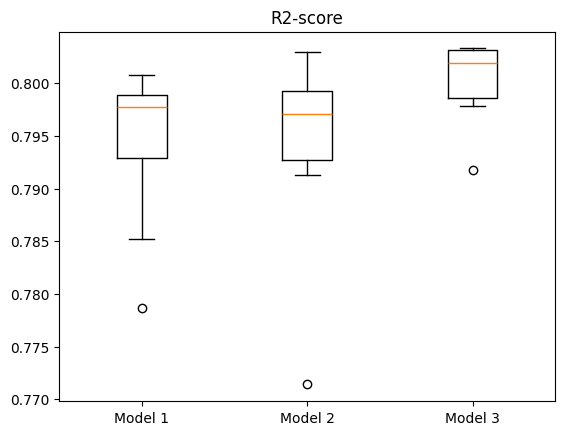

Mean house value from all houses:  207000.0


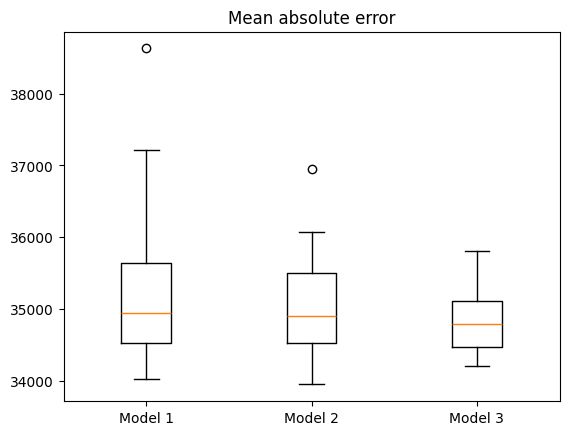

In [6]:
plt.boxplot([r2Score1, r2Score2, r2Score3], labels=["Model 1", "Model 2", "Model 3"])
plt.title("R2-score")
plt.show()
print("Mean house value from all houses: ", round(np.mean(data[:, -1]), -3))
plt.boxplot([MAE1, MAE2, MAE3], labels=["Model 1", "Model 2", "Model 3"])
plt.title("Mean absolute error")
plt.show()

The mean house value is around 207 000, and the best models mean absolute error is around 34 200, which is around $16.5\%$.